In [1]:
%matplotlib notebook

In [2]:
import sys
sys.path.append("../")

In [3]:
import numpy as np
from pickle import load, dump
from pathlib import Path
from tqdm import tqdm
import torch
from torchvision.utils import make_grid
import torchvision.transforms as T
from torchvision.transforms.functional import to_pil_image
from PIL import Image
from multiprocessing import Pool
from scripts.image.kmeans import kmeans
import pandas as pd
import matplotlib.pyplot as plt

Let's open and get the data from the pickles file

In [4]:
def get_data(root: Path):
    data = None
    for encode_path in tqdm(list(root.glob("*.pk"))):
        with open(encode_path, "rb") as f:
            batch = load(f)
            batch["indxs"] = batch["indxs"].numpy()
        if data is None:
            data = batch
        else:
            data["x"] = np.concatenate([data["x"], batch["x"]])
            data["indxs"] = np.concatenate([data["indxs"], batch["indxs"]])
            data["image_paths"] += batch["image_paths"]
            
    return data

In [5]:
data = get_data(Path("../temp/embeddings/"))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 335/335 [00:02<00:00, 163.24it/s]


Let's also add the category to each element

In [6]:
def add_categories_to_data(data, categories):
    data['categories'] = []
    for image_paths in tqdm(data['image_paths']):
        # e.g.rf100/chess-pieces-mjzgj/train/images/foo.jpg'
        dataset_name = Path(image_paths).parts[1]
        category = categories.loc[dataset_name].category
        data['categories'].append(category)
        
    return data

In [7]:
categories = pd.read_csv("../metadata/categories.csv", index_col=0)
data = add_categories_to_data(data, categories)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 40529/40529 [00:00<00:00, 54441.47it/s]


In [83]:
np.unique(data['categories'])

array(['aerial', 'documents', 'electromagnetic', 'microscopic',
       'real world', 'underwater', 'videogames'], dtype='<U15')

sweet, now we have all the data we need. We can now apply `PCA` and cluster them

## Clustering
Let's define some transformations

In [277]:
import torchvision.transforms.functional as F

def read_image_and_transform(image_path, size=(224, 224)):
    image_path = "../" + image_path
    img = Image.open(image_path).convert("RGB")
    img = F.resize(img, size)
    img = F.to_tensor(img)
    return img

#### PCA

In [241]:
def pca(x, k, center=True):
    if center:
        m = x.mean(0, keepdim=True)
        s = x.std(0, unbiased=False, keepdim=True)
        x -= m
        x /= s
    # why pca related to svd? https://www.cs.cmu.edu/~elaw/papers/pca.pdf chap VI   
    U, S, V = torch.linalg.svd(x)
    reduced = torch.mm(x, V[:k].T)

    return reduced

In [300]:
x = torch.from_numpy(data["x"]).float()
x = pca(x, k=2)
print(f"x.shape={x.shape}")
data['x-pca'] = x.numpy()

x.shape=torch.Size([40529, 2])


### Cluster per category

We first want to get the 100 most representative images per category, thus we will first filter per category and run kmeans with 100

In [307]:
def reored_by_left_top(x):
    left, top = x[:,0].min(), x[:,1].max()
    to_compare = torch.tensor([left, top])
    index = ((to_compare - x) ** 2).sum(dim=-1).argsort()
    return x[index]

In [308]:
plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    return fig

In [309]:
def cluter_per_category(category="real world", num_clusters=100):
    filtered_indexes = np.array(data["categories"]) == category
    # let's use the pca ones
    filtered_x = data['x-pca'][filtered_indexes]
    filtered_image_paths = np.array(data['image_paths'])[filtered_indexes]
    # do kmeans
    means, bins = kmeans(torch.from_numpy(filtered_x), num_clusters=num_clusters, num_iters=100)
    means = reored_by_left_top(means)
    # compute distance between means and all points
    diffs = (means[:,None,:] - filtered_x[None,...])
    diffs = (diffs**2).sum(dim=-1)
    indexes = diffs.argmin(axis=1)
    # create the grid
    image_paths = filtered_image_paths[indexes]
    image = show(
        make_grid(
            list(map(read_image_and_transform, image_paths)),
            nrow=25
        )
    )
    return image

100%|██████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 78.42it/s]


<IPython.core.display.Javascript object>


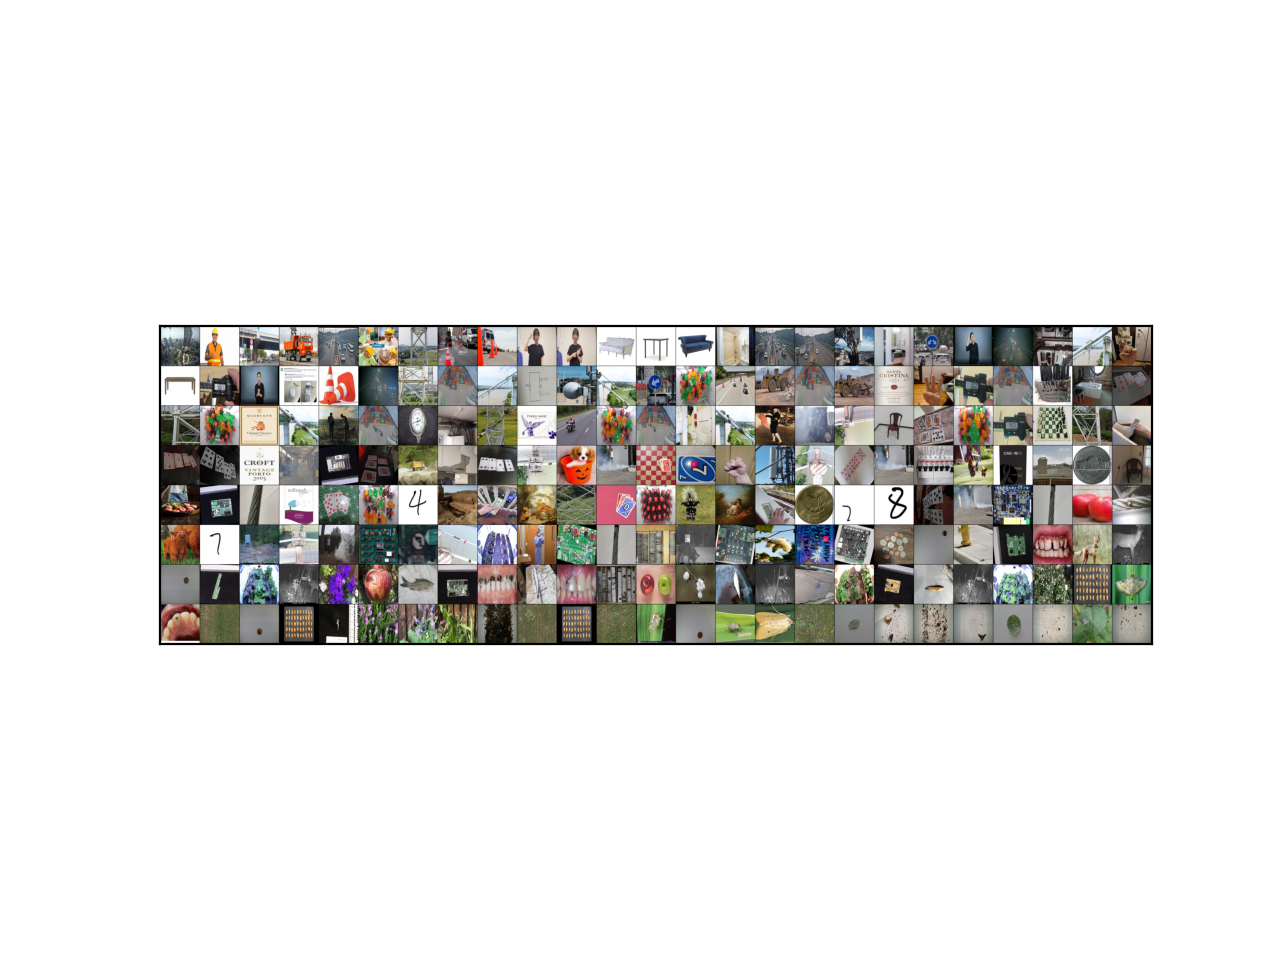

100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1350.97it/s]


<IPython.core.display.Javascript object>


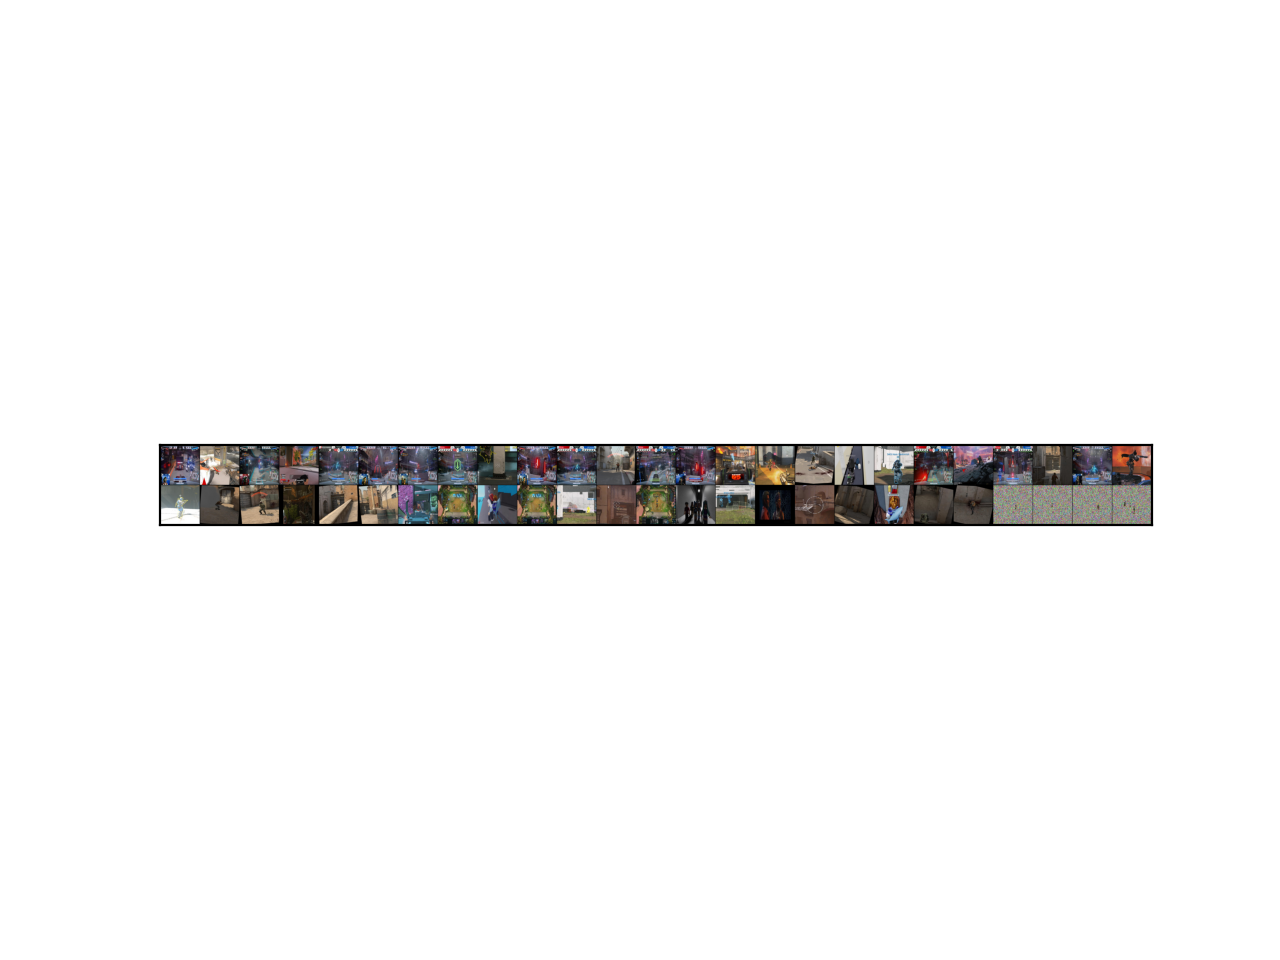

100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1248.20it/s]


<IPython.core.display.Javascript object>


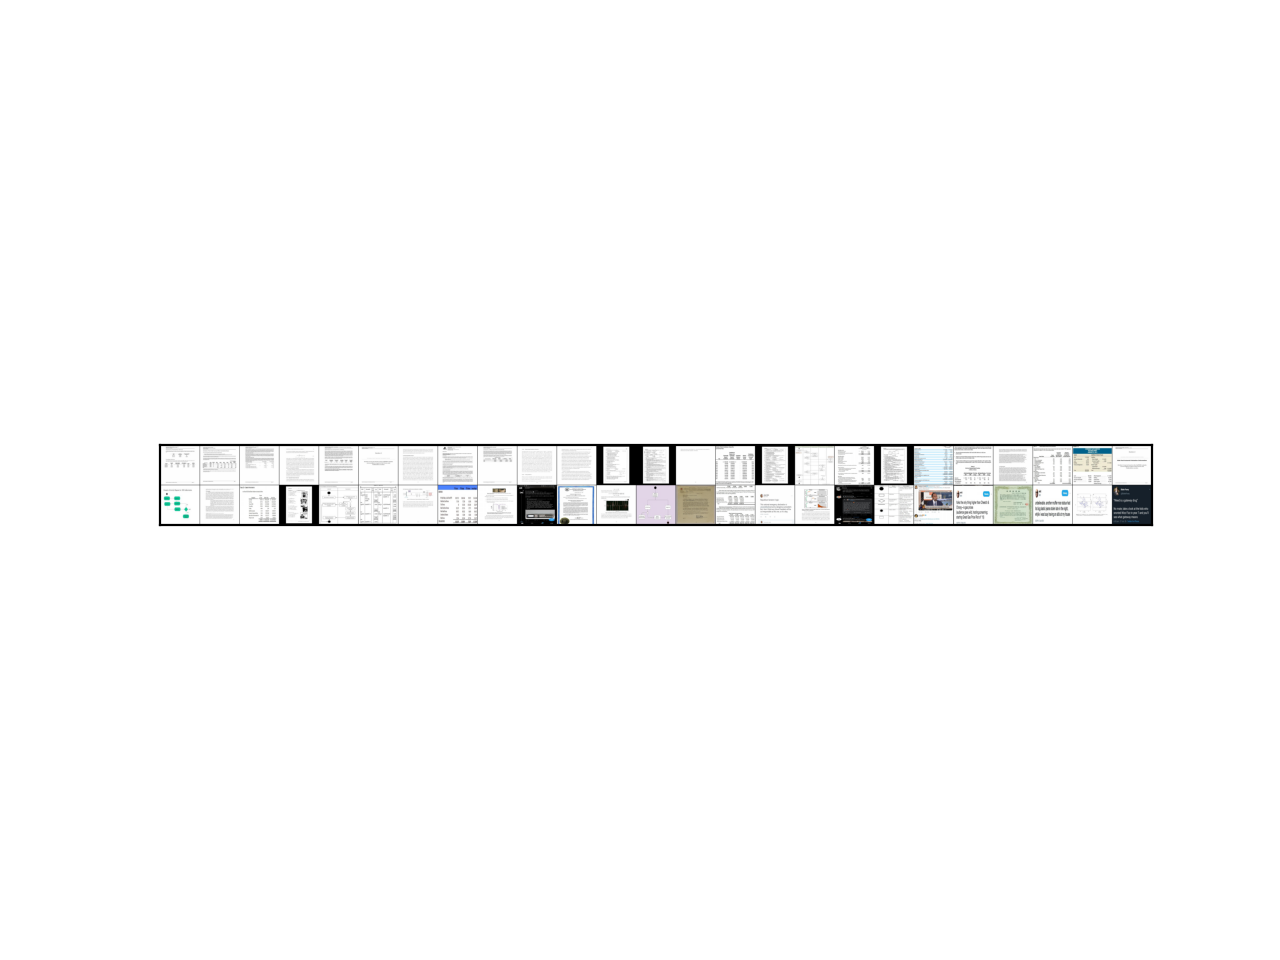

100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1465.79it/s]


<IPython.core.display.Javascript object>


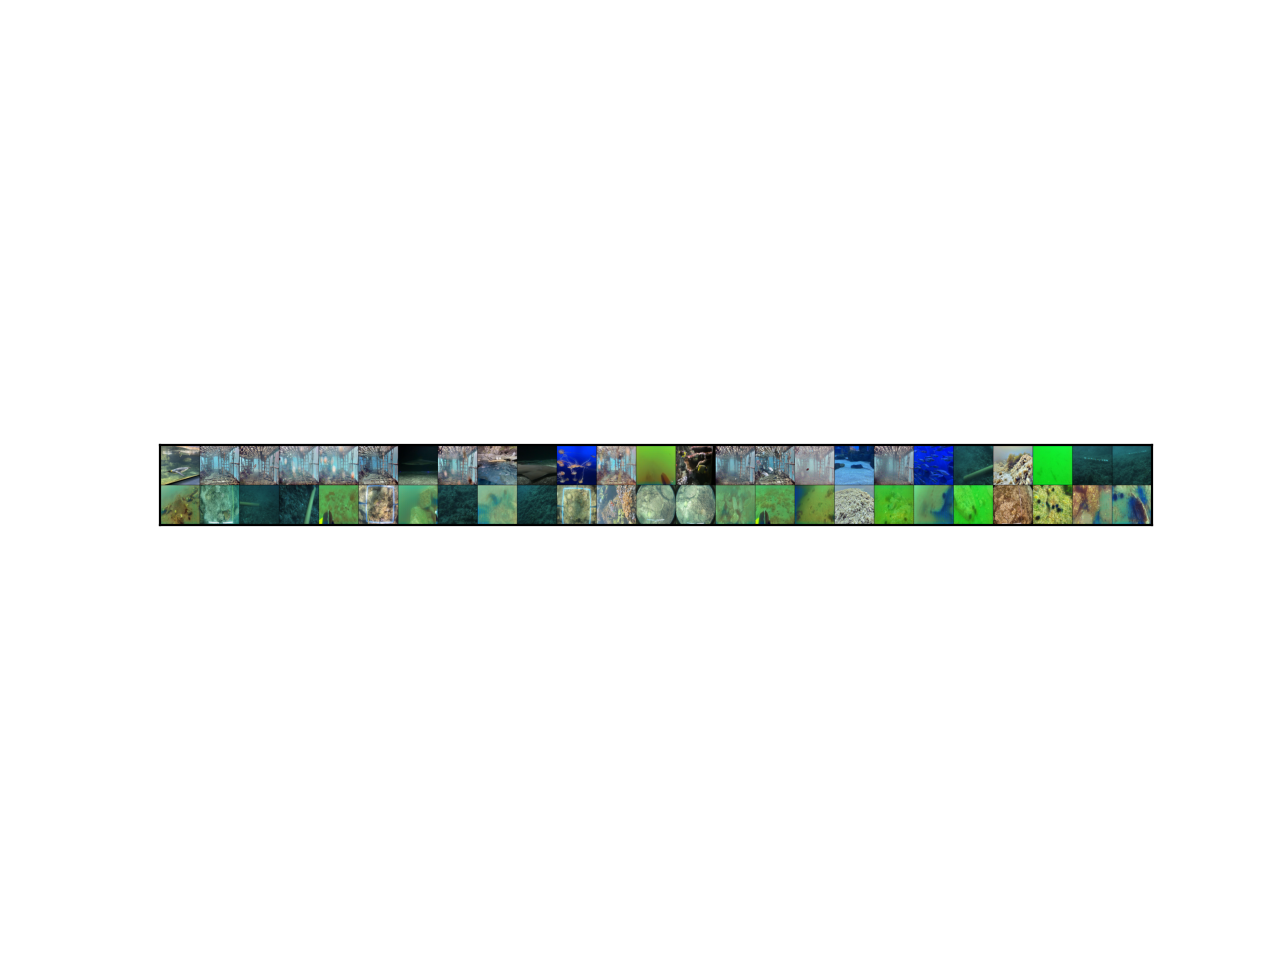

100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1521.05it/s]


<IPython.core.display.Javascript object>


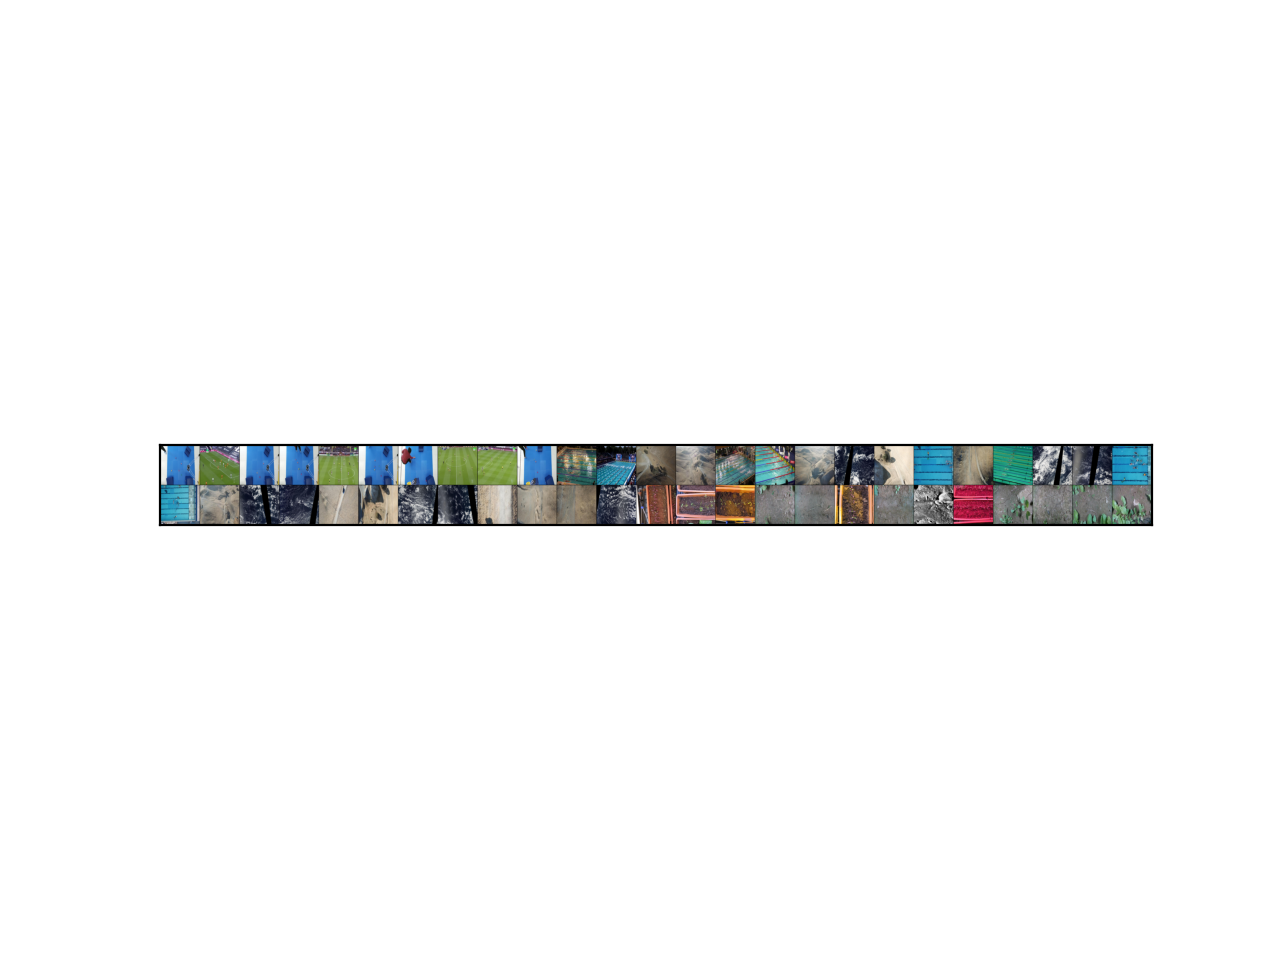

100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 891.28it/s]


<IPython.core.display.Javascript object>


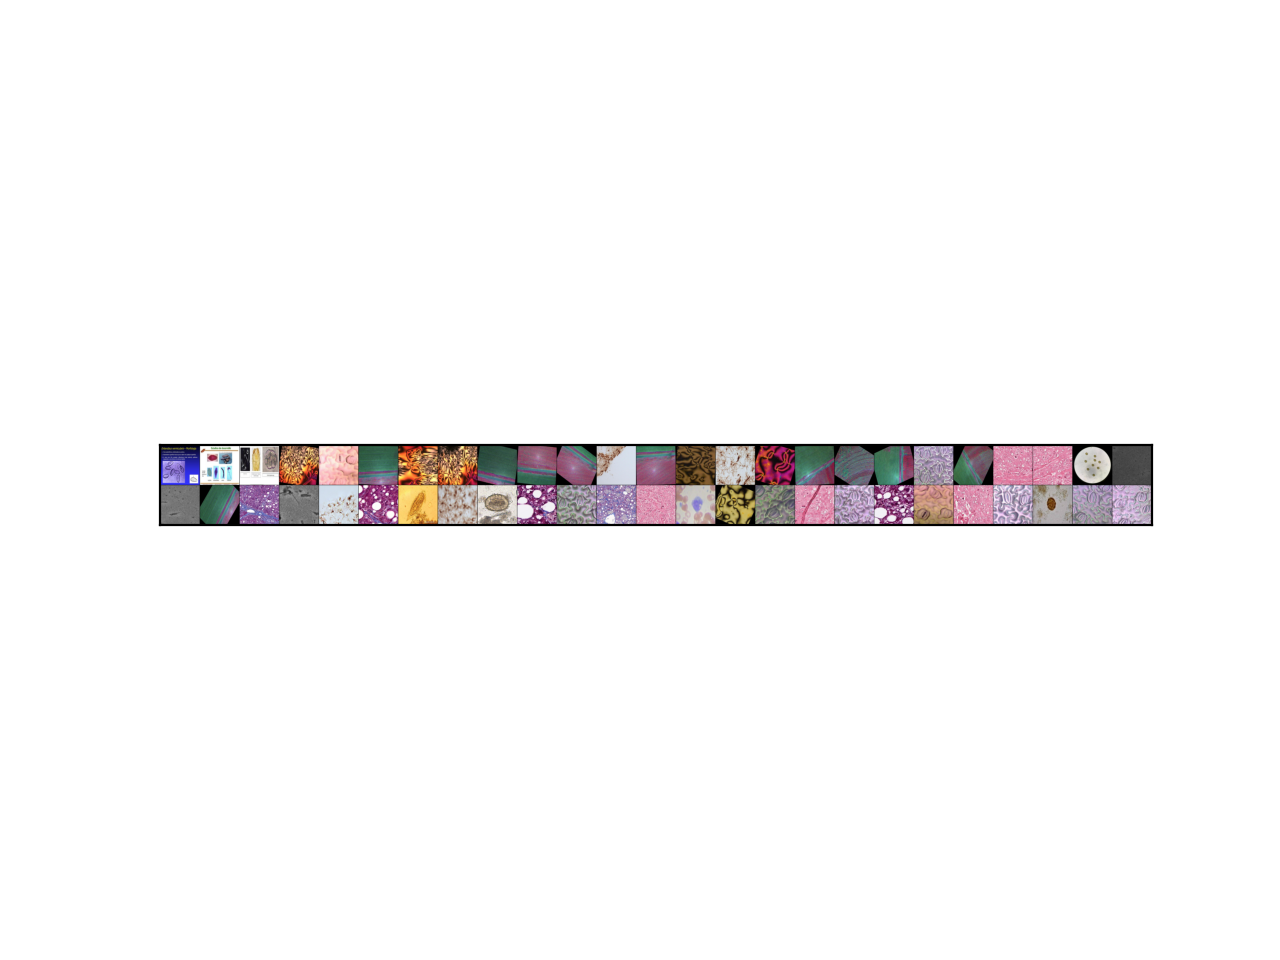

100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 819.19it/s]


<IPython.core.display.Javascript object>


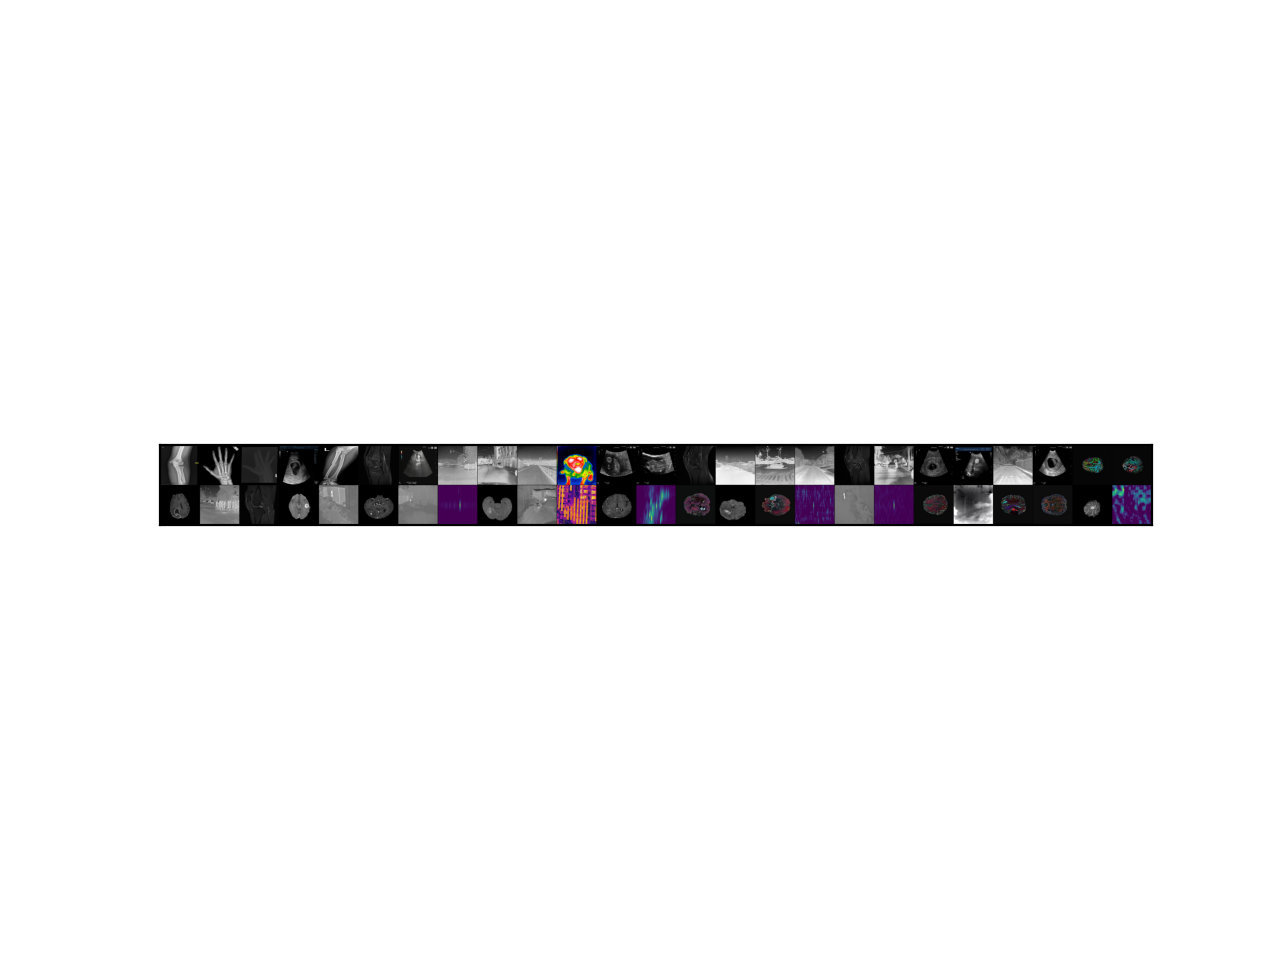

In [311]:
dst = Path("../paper/images/grid/")

for category in categories.category.unique():
    num_clusters = 50
    if category == "real world":
        num_clusters = 200
    cluter_per_category(category, num_clusters).savefig(dst / f"{category}.png", dpi=800, bbox_inches='tight')

## Grid Image

In [316]:
num_clusters = 8 * 8

def make_cluster_grid(num_clusters=100):
    # let's use the pca ones
    x = data['x-pca']
    image_paths = np.array(data['image_paths'])
    # do kmeans
    means, bins = kmeans(torch.from_numpy(x), num_clusters=num_clusters, num_iters=50)
    means = reored_by_left_top(means)
    # compute distance between means and all points
    diffs = (means[:,None,:] - x[None,...])
    diffs = (diffs**2).sum(dim=-1)
    indexes = diffs.argmin(axis=1)
    # create the grid
    image = show(
        make_grid(
            list(map(lambda x: read_image_and_transform(x, size=(128,128)), image_paths[indexes])),
            nrow=8
        )
    )
    return image

100%|███████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 106.08it/s]


<IPython.core.display.Javascript object>


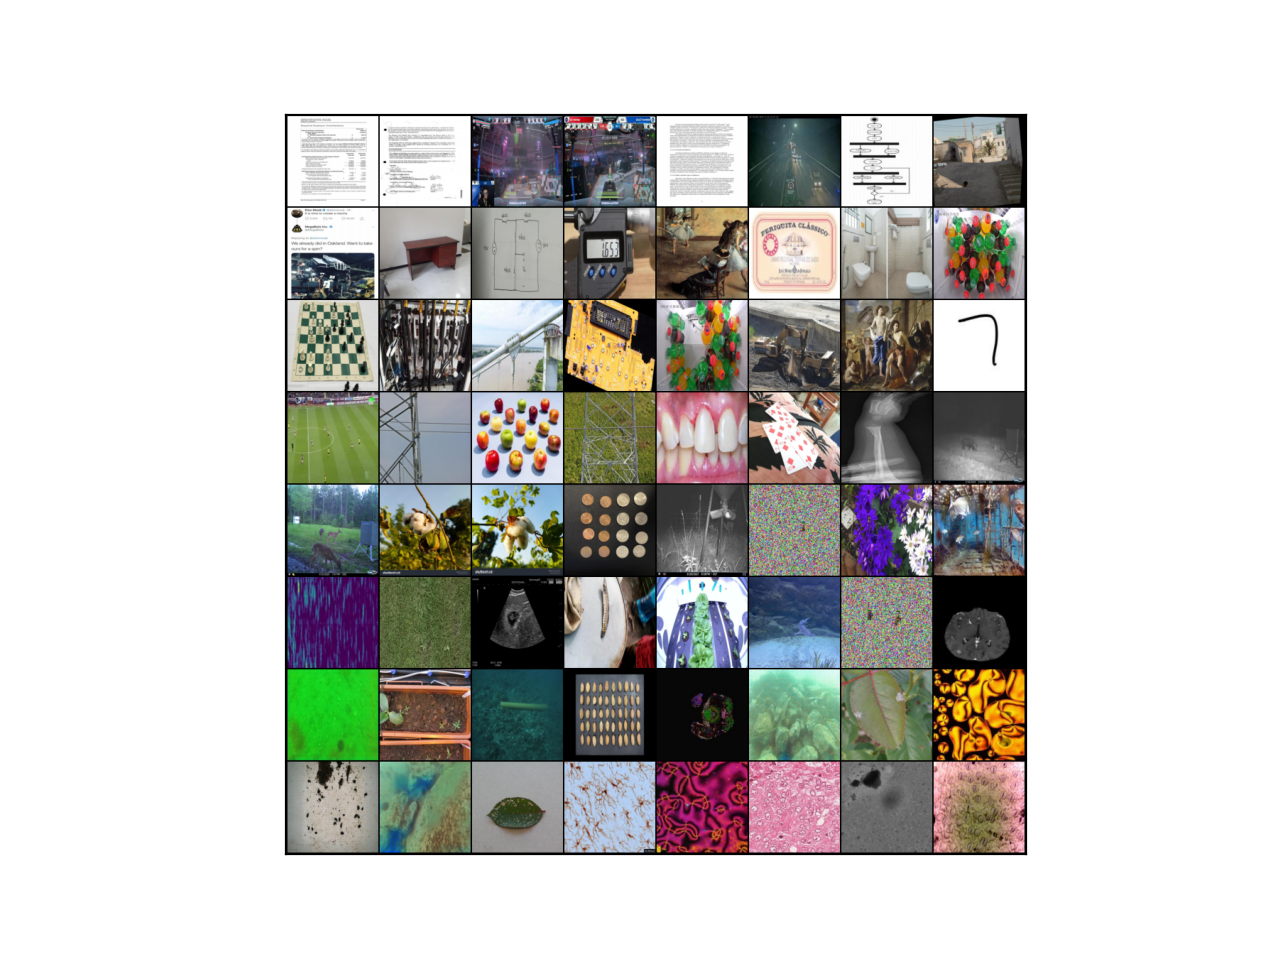

In [317]:
make_cluster_grid(num_clusters).savefig(dst / f"rf100-8x8.png", dpi=800, bbox_inches='tight')